In [14]:
import numpy as np
#import mlflow
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
from PIL import Image
from dataset import *
from save_load import *
from NN_library.AutoUnet.AutoUnet import *
from NN_library.AutoUnet.train_AutoUnet import *
%load_ext autoreload
%autoreload 2

#mlflow.autolog()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Test U-Net

In [4]:
data = dataset_seq()
loaders = get_loaders(data, 1)

In [5]:
name = 'NN_library/AutoUnet/AutoUnet'
args = {'lr' : 0.001, 'epochs' : 20, 'dev' : dev, 'name' : name}
unet = AutoUNet()
unet = load_network(unet, args['name'], args)

In [15]:
L_dam = test(unet, loaders, args)
L_dam = np.array(L_dam)

In [22]:
dam_mean = L_dam.sum(axis=1).mean()
dam_std = L_dam.sum(axis=1).std()
print(dam_mean, '\n', dam_std)

14599.507 
 2765.1548


In [8]:
dam_mean = np.mean(L_dam, axis=0)
dam_std = np.std(L_dam, axis=0)
print(dam_mean, '\n', dam_std)

[6.3706017e-03 3.1962329e+02 8.8256372e+02 1.3121018e+03 1.6138076e+03
 1.8300033e+03 1.9942889e+03 2.1285259e+03 2.2430723e+03 2.3475181e+03] 
 [4.5159057e-02 8.9781906e+01 2.1115269e+02 2.9384766e+02 3.4270303e+02
 3.8045981e+02 4.1562009e+02 4.4802206e+02 4.7859265e+02 5.0693268e+02]


Text(0, 0.5, 'Damage loss')

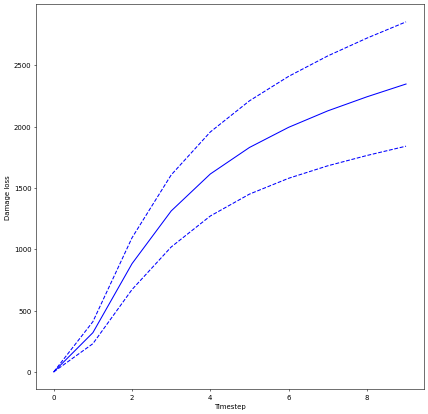

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), dpi=50)

axs.plot(dam_mean, 'b')
axs.plot(dam_mean+dam_std, 'b--')
axs.plot(dam_mean-dam_std, 'b--')
axs.set_xlabel('Timestep')
axs.set_ylabel('Damage loss')

In [6]:
geometry, damage, imp_shrinkage, obs_shrinkage, stiffness = next(iter(loaders['test']))
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])
obs_shrinkage = obs_shrinkage.to(args['dev'])
stiffness = stiffness.to(args['dev'])

In [7]:
unet = unet.to(args['dev'])

In [10]:
seq_test_dam = []

for n in range(10):
    if n == 0:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], damage[:,[n],:,:]], axis=1)
    else:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], y.detach()], axis=1)
    y = unet(x)
    seq_test_dam.append(y[0,0].detach().cpu())

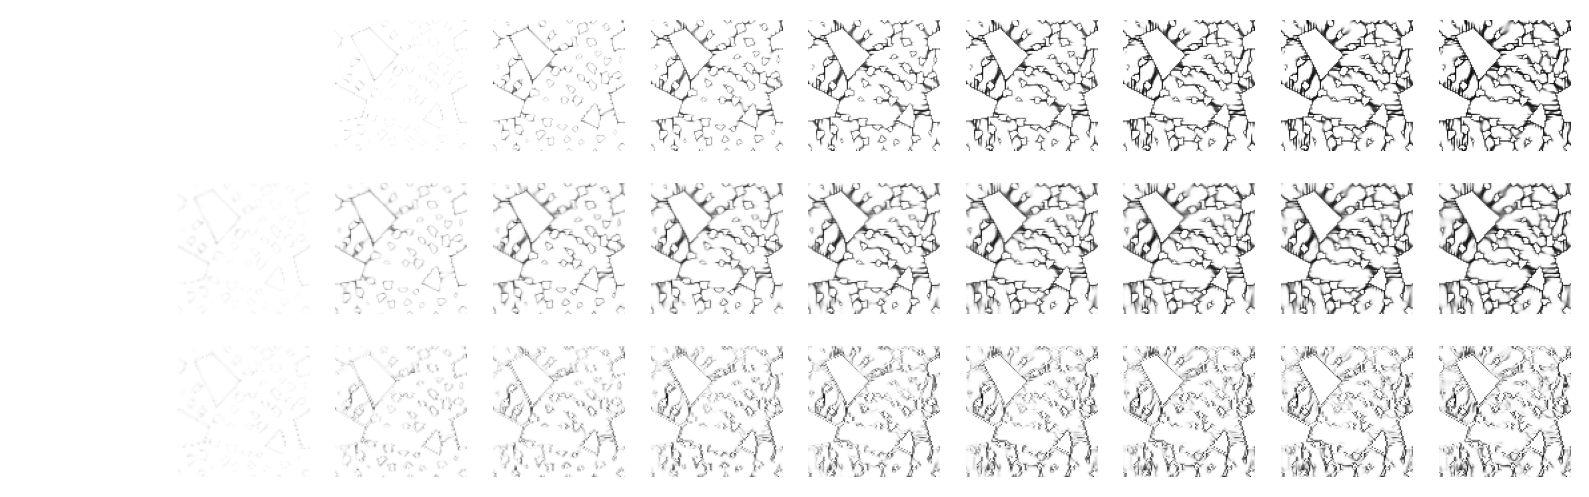

In [13]:
n_samples = 10
fig, axs = plt.subplots(nrows=3, ncols=n_samples, figsize=(n_samples, 3), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow(damage[0, i].cpu().detach().cpu().numpy(), cmap='Greys', vmin=0, vmax=1)
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(seq_test_dam[i-n_samples].cpu(), cmap='Greys', vmin=0, vmax=1)
    axs.flat[i].set_axis_off()
for i in range(2*n_samples, 3*n_samples):
    axs.flat[i].imshow(np.abs((seq_test_dam[i-3*n_samples]-damage[0, i-3*n_samples].cpu()).detach().cpu().numpy()), cmap='Greys', vmin=0, vmax=1)
    axs.flat[i].set_axis_off()

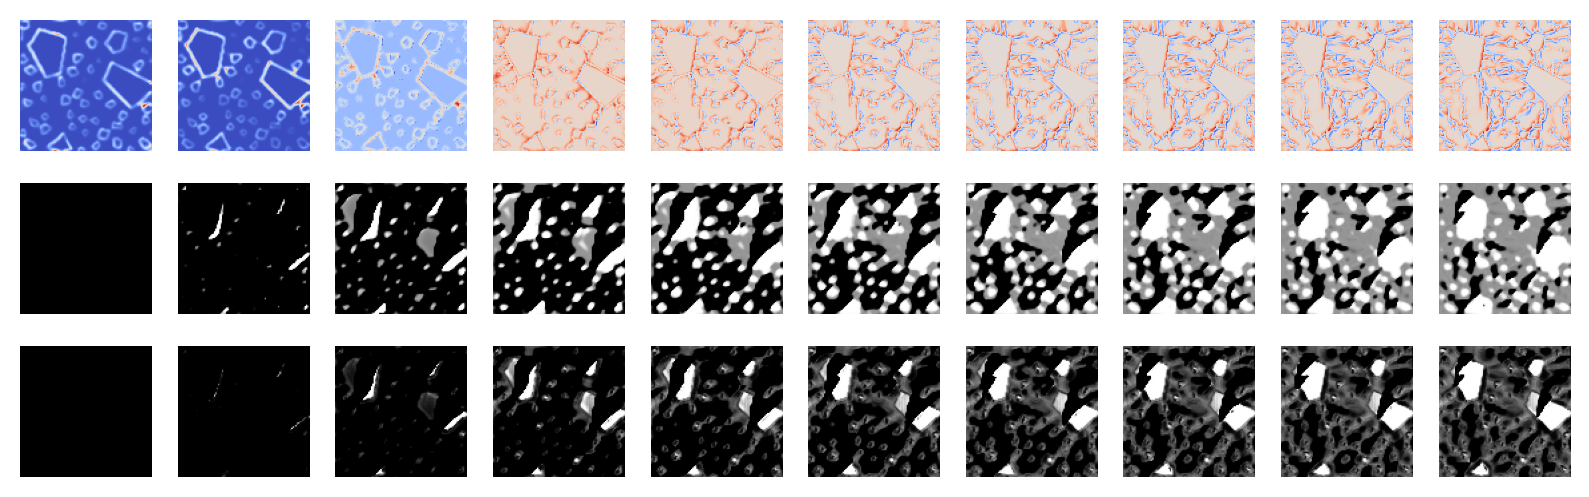

In [15]:
n_samples = 10
fig, axs = plt.subplots(nrows=3, ncols=n_samples, figsize=(n_samples, 3), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow((seq_test_dam[i]-damage[0, i].cpu()).detach().cpu().numpy(), cmap='coolwarm')
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(seq_test_shr[i-n_samples].cpu().numpy(), cmap='Greys', vmin=0, vmax=1)
    axs.flat[i].set_axis_off()
for i in range(2*n_samples, 3*n_samples):
    axs.flat[i].imshow(seq_test_stiff[i-2*n_samples].cpu().numpy(), cmap='Greys', vmin=0, vmax=1)
    axs.flat[i].set_axis_off()

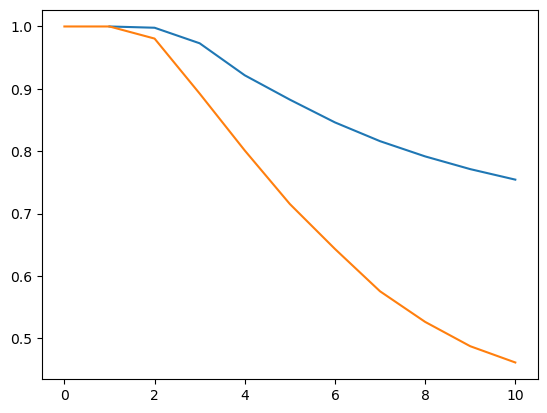

In [16]:
stiffness_mean = np.array([np.array(im) for im in seq_test_stiff])
plt.plot(np.arange(1,11),stiffness_mean.mean((1,2)))
plt.plot(stiffness[0].cpu() / stiffness[0,0].cpu())

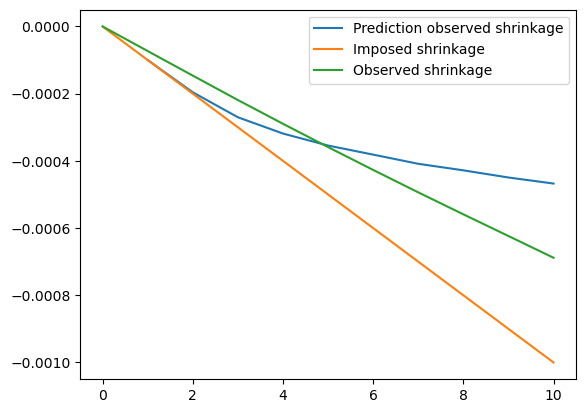

In [17]:
shr_mean = np.array([np.array(im) for im in seq_test_shr])
plt.plot(np.arange(1,11), (shr_mean.mean((1,2)) * imp_shrinkage[0,1:,0,0].cpu().numpy()))
plt.plot(imp_shrinkage.cpu().numpy().mean((0,2,3)))
plt.plot(obs_shrinkage[0].cpu().numpy())
plt.legend(['Prediction observed shrinkage', 'Imposed shrinkage', 'Observed shrinkage'])

Extrapolate

In [10]:
for n in range(10):
    x = torch.cat([geometry, imp_shrinkage[:,[9],:,:] - (n+1)*1e-4, y.detach()], axis=1)
    y = unet(x)
    seq_test_dam.append(y[0,0].detach())
    seq_test_shr.append(y[0,1].detach())

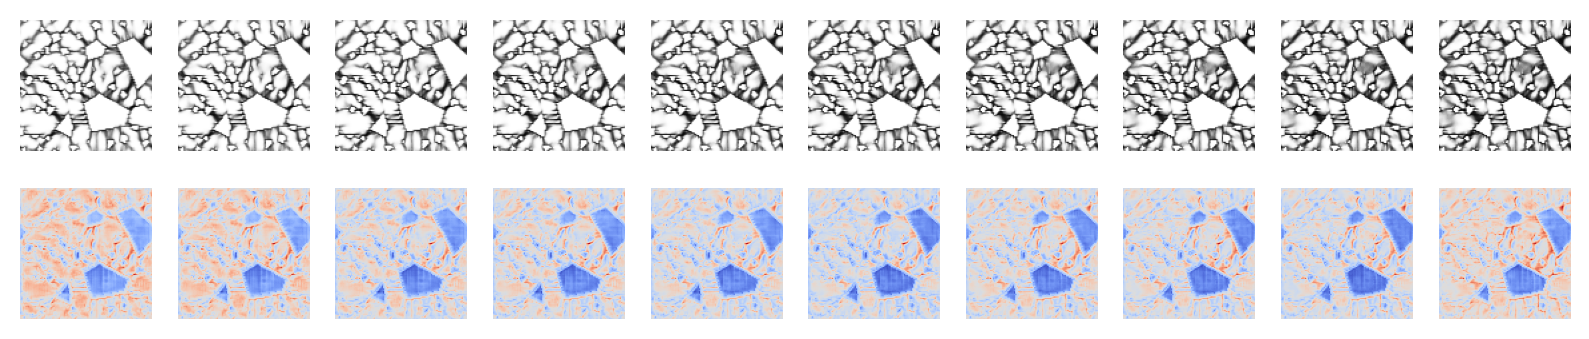

In [11]:
n_samples = 10
fig, axs = plt.subplots(nrows=2, ncols=n_samples, figsize=(n_samples, 2), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow((seq_test_dam[i+n_samples]).detach().cpu().numpy(), cmap='Greys', vmin=0, vmax=1)
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(seq_test_shr[i].cpu().numpy(), cmap='coolwarm')
    axs.flat[i].set_axis_off()

Skip

In [12]:
geometry, damage, imp_shrinkage, obs_shrinkage = next(iter(loaders['test']))
geometry = geometry.to(args['dev'])
damage = damage.to(args['dev'])
imp_shrinkage = imp_shrinkage.to(args['dev'])
obs_shrinkage = obs_shrinkage.to(args['dev'])

In [17]:
seq_test_dam = []
seq_test_shr = []

for n in range(0,10,3):
    if n == 0:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], damage[:,[n],:,:], damage[:,[n],:,:]], axis=1)
    else:
        x = torch.cat([geometry, imp_shrinkage[:,[n],:,:], y.detach()], axis=1)
    y = unet(x)
    seq_test_dam.append(y[0,0].detach())
    seq_test_shr.append(y[0,1].detach())

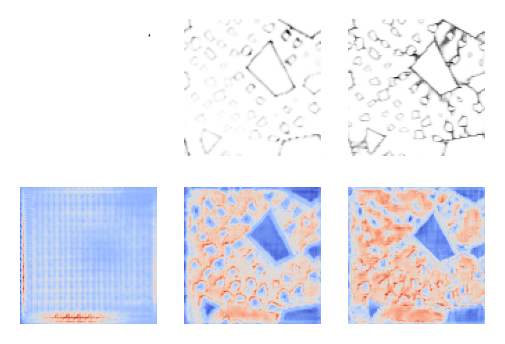

In [18]:
n_samples = 3
fig, axs = plt.subplots(nrows=2, ncols=n_samples, figsize=(n_samples, 2), dpi=200)
for i in range(n_samples):
    axs.flat[i].imshow((seq_test_dam[i]).detach().cpu().numpy(), cmap='Greys')
    axs.flat[i].set_axis_off()
for i in range(n_samples, 2*n_samples):
    axs.flat[i].imshow(seq_test_shr[i-n_samples].cpu().numpy(), cmap='coolwarm')
    axs.flat[i].set_axis_off()